<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [1]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv
!ls -al data
!wc -l data/*.csv

2025-03-24 23:01:03 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv [61194/61194] -> "data/titanic.csv" [1]
total 68
drwxr-xr-x 2 root root  4096 Mar 24 23:01 .
drwxr-xr-x 1 root root  4096 Mar 24 23:01 ..
-rw-r--r-- 1 root root 61194 Mar 24 23:01 titanic.csv
892 data/titanic.csv


In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [3]:
raw_data = pd.read_csv('./data/titanic.csv', index_col='PassengerId')
# note that the PassengerId column is 1-indexed, instead of 0.
# Survived column: 1=servived, 0=not survived
raw_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [6]:
raw_data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Data Cleaning

In [9]:
raw_data.isna().sum(axis=0)

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687


In [7]:
# from the above counts we see Cabin has too many missing data (687 out of 891), so drop it
cleaned_data = raw_data.drop('Cabin', axis=1)

# there are 177 records with missing Age values, we can either fill them with
# average or median values. Here we will use median (which happens to be 28)
median_age = cleaned_data['Age'].median()
cleaned_data['Age'] = cleaned_data['Age'].fillna(median_age)

# Embarded is the port of embarkation, having 3 values: C=Cherbourg, Q=Queenstown,
# S=Southhampton. With 2 rows missing the value, we can add new value U=unknown
cleaned_data['Embarked'] = cleaned_data['Embarked'].fillna('U')

# save to file, don't add index column
cleaned_data.to_csv('./data/clean_titanic_data.csv')

# Data PreProcessing

In [44]:
preproc_data = pd.read_csv('./data/clean_titanic_data.csv', index_col='PassengerId')

# turn numerical values into catagorical using one-hot
gender_cols = pd.get_dummies(preproc_data['Sex'], prefix='Sex')
embarked_cols = pd.get_dummies(preproc_data['Embarked'], prefix='Embarked')

preproc_data = pd.concat([preproc_data, gender_cols, embarked_cols], axis=1)
preproc_data = preproc_data.drop(['Sex', 'Embarked'], axis=1)


## Rule of thumb to do one-hot or not:

In [46]:
# The Pclass column has 3 values 1,2,3. Should we catagorise it with one-hot?
# If we keep them as-is, the model may assume ordering among them.
# But do they have such order?
pclass_counts = preproc_data['Pclass'].value_counts().rename('pclass_total').sort_index()
pclass_survived_counts = preproc_data[preproc_data['Survived']==1]['Pclass'].value_counts().rename('survive_total').sort_index()
pclass_survived_ratio = (pclass_survived_counts / pclass_counts * 100).rename('survive_ratio(%)').sort_index()

pclass_stats = pd.concat([pclass_counts, pclass_survived_counts, pclass_survived_ratio], axis=1)
print(pclass_stats)

        pclass_total  survive_total  survive_ratio(%)
Pclass                                               
1                216            136         62.962963
2                184             87         47.282609
3                491            119         24.236253


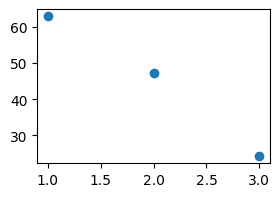

In [47]:
plt.figure(figsize=(3,2))
plt.scatter([1,2,3], pclass_survived_ratio)

seeing above result, there seems to be a linear relationship between the survival rate and the value of the Pclass. So we can keep Pclass as-is.

## Binning
For the Age column we can create bins of 0-10, 11-20, ... and make each bin a catagory using one-hot.

In [48]:
preproc_data['Age'].max()

80.0

In [49]:
bins = [i for i in range(0, 81, 10)] # bin boundries
binned_ages = pd.cut(preproc_data['Age'], bins).rename('Binned_age')
preproc_data = pd.concat([preproc_data, binned_ages], axis=1)
preproc_data = preproc_data.drop(['Age'], axis=1)
preproc_data

,Survived,Pclass,Name,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,Binned_age
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,False,True,False,False,True,False,"(20, 30]"
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,True,False,True,False,False,False,"(30, 40]"
3,1,3,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,True,False,False,False,True,False,"(20, 30]"
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,True,False,False,False,True,False,"(30, 40]"
5,0,3,"Allen, Mr. William Henry",0,0,373450,8.0500,False,True,False,False,True,False,"(30, 40]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,0,211536,13.0000,False,True,False,False,True,False,"(20, 30]"
888,1,1,"Graham, Miss. Margaret Edith",0,0,112053,30.0000,True,False,False,False,True,False,"(10, 20]"
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,2,W./C. 6607,23.4500,True,False,False,False,True,False,"(20, 30]"


## Drop columns

In [53]:
# passenger name and ticket numbers are unique per record anyway,
# so they can be dropped.
preproc_data = preproc_data.drop(['Name', 'Ticket'], axis=1)

KeyError: "['Name', 'Ticket'] not found in axis"

In [55]:
preproc_data

,Survived,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,Binned_age
PassengerId,,,,,,,,,,,,
1,0,3,1,0,7.2500,False,True,False,False,True,False,"(20, 30]"
2,1,1,1,0,71.2833,True,False,True,False,False,False,"(30, 40]"
3,1,3,0,0,7.9250,True,False,False,False,True,False,"(20, 30]"
4,1,1,1,0,53.1000,True,False,False,False,True,False,"(30, 40]"
5,0,3,0,0,8.0500,False,True,False,False,True,False,"(30, 40]"
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0,0,13.0000,False,True,False,False,True,False,"(20, 30]"
888,1,1,0,0,30.0000,True,False,False,False,True,False,"(10, 20]"
889,0,3,1,2,23.4500,True,False,False,False,True,False,"(20, 30]"


In [54]:
preproc_data.to_csv('./data/preprocessed_titanic_data.csv')

# What if...